## Dr.Bot Reference Demo

## What to submit

The link to your notebook package is automatically generated by Kaggle and will always appear in the **first cell of your notebook**, provided you’ve correctly set it up as a package. For example, in our case, the link looks like:

`talhacoskun/dr-bot-baseline-model-tutorial/versions/6`

This is the exact link you will submit for the competition. Please refer to the main competition page for detailed submission instructions.

Because Kaggle saves all previous versions of your packages, it’s important to double-check that the link you provide corresponds to the **specific version you intend to submit**. We will evaluate **only the version you officially submit**, so please ensure it is your final, intended submission.



## 1. Overview
This notebook introduces you to fine-tuning an adapter on a Mistral model for our medical Q&A task, then packages the adapter (plus tokenizer) into a reusable Kaggle Package with a simple `Model.predict()` API.

1. Uses **Add-ons → Install Dependencies** to handle libraries
2. **Load & quantize** the base model in 4-bit to fit Kaggle’s memory constraints  
3. **Fine-tune** on your CSV dataset of physician Q&As  
4. **Saves** the small adapter + tokenizer into the`assets file`  
5. **Export** a `Model` class that, on import:  
   - downloads the official model base via `kagglehub`  
   - applies the adapter  
   - exposes `.predict(prompt: str) → str`

---

## 2. Submission

Once your package builds and your `Model.predict()` runs correctly, follow these steps to submit:

1. **Save & Export Your Package**  
   - Click **Save Version** in the Kaggle Notebook editor.  
   - Confirm in the **Output** tab that you see a successful package build and that `package/core.py` was generated.
   - Notebook page should say something like : package = kagglehub.package_import('talhacoskun/dr-bot-demo-notebook/versions/5')

2. **Share the Notebook with Organizers**  
   - Copy the URL of your saved notebook.
   - Ensure your notebook is properly shared so organizers can access it (Kaggle Usernames: talhacoskun, ahsenme, derinsozen1). 

3. **Submit Your Entry**  
   - In the competition’s submission form, paste the **Notebook URL**.  
   - Organizers will import your package via `kagglehub.package_import()` and call your `Model.predict()` on the test set.  

Your adapter-only package ensures the base model is downloaded automatically and your fine-tuned weights are applied at runtime. Organizers simply need your notebook link to evaluate your `Model.predict()` implementation.

Afterwards, we will export your model's responses and judges will evaluate.

---

## 3. Example Usage:

After exporting to a kaggle package, we should be able to use your model like below:

```python
import kagglehub
package = kagglehub.package_import('notebook package link')
model = package.Model()
print(model.predict("I’ve been on amoxicillin for 3 days and my ear still hurts. Is that normal?"))
```

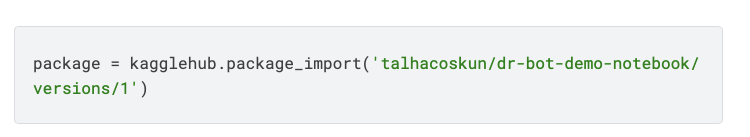

# Introduction to fine-tuning LLMs
This notebook serves as guide to fine tuning an LLM for the Dr. Bot competition. This notebook uses Mistral 7b Instruct and the HuggingFace transformers library, but you are free to use other models and libraries

For more information on Mistral 7b: [Documentation](https://mistral.ai/news/announcing-mistral-7b)

For more information of HF Transformers: [Documentation](https://huggingface.co/docs/transformers/en/index)

The code below is needed to create a Kaggle package.

In [ ]:
#| default_exp core

### Import Python Packages

You need to import the packages that you need for your notebook. Below are the packages needed for this notebook with brief explanations.

Before you can start building or training your model, you need to import the Python packages (libraries) that will give you the tools to work with models and data. Here’s a quick overview of what each one does:

###  `transformers`
This is the popular **Hugging Face library**, which gives you access to thousands of **pre-trained language models** (like GPT, BERT, T5, etc.). It’s what you’ll use to load, fine-tune, and run these models.

### `datasets`
A companion library from Hugging Face that makes it **easy to load, preprocess, and handle datasets** for training and evaluation. Supports many ready-made datasets and can also load your own data.

### `accelerate`
Helps you **train your models faster and more efficiently**, especially if you have access to multiple GPUs or TPUs. It takes care of complicated device placement and parallelization.

### `bitsandbytes`
A library that lets you do **memory-efficient training**, such as quantization (training with fewer bits). This is super helpful if you’re working with large models on limited hardware.

- **To install non standard dependencies with pip, go to Add-ons -> Install Dependencies at the top of the notebook.**

In [ ]:
import os
import torch
import kagglehub
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

### Quantization
####  Memory Problem
Large language models are massive because they usually store their weights as **32-bit floating-point numbers**. For example, a model with **7 billion parameters (7B)** in full precision needs about **28 GB of memory** — far too large for most consumer GPUs.

####  How we solve it
We use a technique called **quantization**, which reduces the precision from **32-bit to 4-bit**. This can **cut memory usage by up to 75%**, making it possible to run huge models on standard hardware. Quantization is now a common practice for both training and deploying large language models (LLMs).


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

quantization_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_compute_dtype=torch.float16,)
model = AutoModelForCausalLM.from_pretrained("/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1", device_map="auto", quantization_config=quantization_config)

## Importing Dataset
1.  Load your training data from a CSV file into a pandas DataFrame

2. Convert the DataFrame into a HuggingFace Dataset the model can understand

#### Importing Your Own Dataset

Adding Your Dataset to Kaggle:
Upload Dataset:

1. Go to kaggle.com/datasets

2. Click "Create Dataset"

3. Upload your CSV file

4. On the right side of your notebook, click `Add Input` and select your dataset

```Python
# Replace with your dataset path
df = pd.read_csv("/kaggle/input/YOUR-DATASET-NAME/your_file.csv")

# Convert to HuggingFace format
hf_ds = Dataset.from_pandas(df)
```

In [ ]:
from datasets import Dataset
import pandas as pd
from transformers import AutoTokenizer

## this is how you would use the competition training set which is already uploaded
## change the link for manually added data
df = pd.read_csv(
    "/kaggle/input/dr-bot-training-data/training_data.csv",
    encoding="latin-1"
)

# Create HuggingFace dataset from pandas DataFrame
hf_ds = Dataset.from_pandas(df)

### Tokenizer

Large language models don’t actually understand raw human language — they only work with **numbers**.  
A **tokenizer** serves as a crucial translator between human-readable text and the numerical format that the model needs.

- It takes your input text (like a sentence or paragraph) and breaks it down into **smaller units called tokens**. These tokens are then mapped to **unique integer IDs** that the model can process.
- This allows the model to understand and predict patterns based on these numeric representations, rather than on the words themselves.

Similarly, after the model generates predictions in the form of token IDs, the tokenizer converts these numbers **back into text** so you can read the output.

In short, the tokenizer acts as a **bridge** between human language and the model’s internal numerical world — handling both the encoding (text → numbers) and decoding (numbers → text).

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1", padding_side="left")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.eos_token_id = 2

### Format Data For Conversation
The Problem: Models like Mistral, ChatGPT, and Llama were trained on conversations with specific formatting. Your training data must match this exact format, or the model won't learn properly.

We address this problem using `Chat Templates`, they are a standardized way to structure conversations for AI models, you can learn more [here](https://huggingface.co/learn/llm-course/en/chapter11/2)

The user and assistant model our dataset as a conversation between user and the AI so that the model correctly learns what It's supposed to respond to the user with. We embed more instructions into the question to guide the LLM on what kind of answers we want. 

It is crucial to stay consistent in your formatting between pre-training, fine-tuning, and generation for good performance.

In [ ]:
def format_conversation_batch(batch):
    """Format batch without system role to avoid template error"""
    
    formatted_texts = []
    
    # Define system instruction to merge with user message
    system_instruction = "You are an experienced primary-care physician. Provide concise, professional medical responses based on sound medical knowledge and current best practices."
    
    # Process each example in the batch
    for i in range(len(batch['Question'])):
        question = str(batch['Question'][i]).strip()
        response = str(batch['Physician Response'][i]).strip()
        
        # Merge system instruction with user question
        enhanced_question = f"{system_instruction}\n\nQuestion: {question}"
        
        # Create chat format with only user/assistant roles
        messages = [
            {"role": "user", "content": enhanced_question},
            {"role": "assistant", "content": response}
        ]
        
        # Apply chat template
        formatted_text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        
        formatted_texts.append(formatted_text)
    
    return {"text": formatted_texts}

### Tokenizing function

We define a function that uses the tokenizer on our formatted data, and in the next cell we execute both steps on the datatset.

In [ ]:
def tokenize_function(examples):
    """Tokenize the formatted text into input_ids and labels"""
    model_inputs = tokenizer(
        examples["text"],
        max_length=1024,
        truncation=True,
        padding=False,
        return_tensors=None
    )

    # For causal LM, labels are the same as input_ids
    model_inputs["labels"] = model_inputs["input_ids"].copy()
    return model_inputs

In [ ]:
# Apply preprocessing
tokenized_dataset = hf_ds.map(
    format_conversation_batch,
    batched=True,
    remove_columns=hf_ds.column_names,
).map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

print("Successfully formatted dataset!")
print("Dataset size:", len(tokenized_dataset))

### Low Rank Approximation (LoRA)

LoRA is a linear algebra technique that makes fine-tuning large language models practical and affordable.

Instead of updating all parameters, LoRA adds small adapter layers that learn the changes needed for your specific task.

We define our lora configurations here importantly setting `CAUSAL_LM` to configure it to predict the next token, a crucial LLM task

You can learn more about LoRA [here](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora)

In [ ]:
from peft import LoraConfig, get_peft_model
# Configure LoRA for efficient fine-tuning
peft_config = LoraConfig(
    task_type="CAUSAL_LM",
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]  # Mistral attention modules
)

# Apply LoRA to the model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


### Preparing Training Arguments

These define exactly how your model will learn from your data. These settings determine training speed, memory usage, and final model quality.

You can learn about these in more detail [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./medical-mistral-7b-lora",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    save_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    warmup_ratio=0.03,
    weight_decay=0.01,
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    report_to="none",
    label_names=["labels"]
)


### Splitting The Dataset
Here we split the dataset into two parts, one training and one evaluation. We train it on the larger portion and then evaluate how well it learned using a portion it hasn't seen before (evaluation split). 

This is to ensure that the model can work well outside of it's training set and doesn't overfit, learning to memorize the training data instead of learning.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split dataset
train_indices, eval_indices = train_test_split(
    range(len(tokenized_dataset)), 
    test_size=0.1, 
    random_state=42
)

train_dataset = tokenized_dataset.select(train_indices)
eval_dataset = tokenized_dataset.select(eval_indices)

def compute_metrics(eval_pred):
    """Compute perplexity for evaluation"""
    predictions, labels = eval_pred
    # For causal LM, we typically monitor loss/perplexity
    return {}


## Training

Final Setup: Connects all your training components together and starts the actual fine-tuning process.

1. Data Collator: Handles batch preparation and padding

**What is a Data Collator?**
The Data Collator takes individual tokenized examples and combines them into batches that the model can process efficiently. The data may have different lengths and the collator pads shorter examples so all examples in a batch have the same length.

2. Trainer: Orchestrates the entire training process

3. Training: Executes the fine-tuning loop

In [ ]:
from transformers import Trainer, DataCollatorForLanguageModeling, DataCollatorForSeq2Seq

# Data collator for causal language modeling
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    return_tensors="pt"
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


### Save the Model And Tokenizer

This step is crucial because it **saves your fully trained model**, allowing you to reuse it later without having to rerun the entire notebook to train or export it again.


In [ ]:
# Save the fine-tuned model
model.save_pretrained("./medical-mistral-7b-lora-final", save_full_model=False)
tokenizer.save_pretrained("./medical-mistral-7b-lora-final")


# Also save to export package
asset_dir = kagglehub.get_package_asset_path('mistral-pretrained')

model.save_pretrained(asset_dir, save_full_model=False)
tokenizer.save_pretrained(asset_dir)

### Load Up Fine-Tuned Model

In [ ]:
del(model)
del(tokenizer)

In [ ]:
from peft import PeftModel

torch.cuda.empty_cache()

quantization_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_compute_dtype=torch.float16,)

basemodel = AutoModelForCausalLM.from_pretrained("/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1", device_map="auto", quantization_config=quantization_config)

model = PeftModel.from_pretrained(
    basemodel,
    "./medical-mistral-7b-lora-final"
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained("./medical-mistral-7b-lora-final")

## Use Your Fine-Tuned Model

This section takes a user question and generates a medical response using your fine-tuned model.

You must use the exact same format as training data, or the model won't perform optimally.

In [ ]:
def predict(prompt: str, max_new_tokens: int = 256) -> str:
    
    # Use the same system instruction as training for optimal results
    system_instruction = "You are an experienced primary-care physician. Provide concise, professional medical responses based on sound medical knowledge and current best practices."
    
    # Merge system instruction with user prompt (matching training format)
    enhanced_prompt = f"{system_instruction}\n\nQuestion: {prompt}"
    
    # Create chat format with only user role (matching training data)
    messages = [
        {"role": "user", "content": enhanced_prompt}
    ]
    
    # Apply chat template with add_generation_prompt=True for inference
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize the prompt
    inputs = tokenizer(
        formatted_prompt, 
        return_tensors="pt",
        add_special_tokens=False
    ).to("cuda")
    
    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1
        )
    
    # Extract only the generated response
    response = tokenizer.decode(
        outputs[0][len(inputs["input_ids"][0]):], 
        skip_special_tokens=True
    )
    
    return response.strip()


# Test with a medical question
test_question = "My arms sometimes hurt when I sneeze? 28F, ex smoker, no drinking, 5'3, 200 lbs. Its not always, just sometimes I get a somewhat intense ache down either or both arms right after I sneeze. Should I be worried?!"
response = predict(test_question)
print(f"Question: {test_question}")
print(f"Response: {response}")

## Exporting to Kaggle Package

Only cells marked with #| export will be exported to the package. 

Here we will setup the code to initialize the model class by pulling the base model then installing our trained weights.

In [ ]:
#| export

import os
import random
import torch
import kagglehub
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import PeftModel

class Model:
    def __init__(self):
        # 1) Download the base Mistral checkpoint
        base_dir = kagglehub.model_download(
            'mistral-ai/mistral/pytorch/7b-instruct-v0.1-hf/1'
        )

        # 2) Configure 4-bit quantization exactly as in training
        quantization_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_compute_dtype=torch.float16,)

        # 3) Load the quantized base model (auto-sharded)
        base_model = AutoModelForCausalLM.from_pretrained(
            base_dir,
            quantization_config=quantization_config,
            device_map="auto"
        )

        # 4) Load and adjust the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            base_dir,
            trust_remote_code=True,
            padding_side="left"
        )
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.eos_token_id = 2

        # 5) Path to pre-trained model
        adapter_dir = kagglehub.get_package_asset_path('mistral-pretrained')

        # 6) Attach the LoRA adapters on top of the base model
        self.model = PeftModel.from_pretrained(
            base_model,
            adapter_dir
        )

        # 7) Eval mode + fixed seeds if desired
        self.model.eval()
        torch.manual_seed(42)
        random.seed(42)

    def predict(self, prompt: str, max_new_tokens: int = 256) -> str:
        # Use your original system instruction
        system_instruction = "You are an experienced primary-care physician. Provide concise, professional medical responses based on sound medical knowledge and current best practices."
        enhanced_prompt = f"{system_instruction}\n\nQuestion: {prompt}"

        messages = [
        {"role": "user", "content": enhanced_prompt}
        ]

        
        formatted_prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # Tokenize & move to the correct device
        inputs = self.tokenizer(
        formatted_prompt, 
        return_tensors="pt",
        add_special_tokens=False
        ).to("cuda")

        # Generate response
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.eos_token_id,
                repetition_penalty=1.1
            )

        # Decode only the newly generated tokens and return our answer
        response = self.tokenizer.decode(
            outputs[0][len(inputs["input_ids"][0]):], 
            skip_special_tokens=True
        )
        return response.strip()
